In [4]:
import scipy
from scipy.io import wavfile
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal
import osascript
from gtts import gTTS 
import os 
import pyaudio
import wave
import keyboard  # using module keyboard
import soundfile as sf
import math
import pyloudnorm as pyln
from sys import byteorder
from array import array
from struct import pack
import librosa
from scipy.signal import butter, sosfiltfilt
import python_speech_features
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from ipynb.fs.full.Pitch_vector import get_pitch_stats
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 
import time
from ipynb.fs.full.concat_project2 import get_lpc_stats
from ipynb.fs.full.Pitch_vector import get_spectral_stats
import  ipynb.fs.full.concat_project2 as emotex_lib

Using TensorFlow backend.


In [5]:
x, y = emotex_lib.data_extraction_RAVDESS('../../RAVDESS')

KeyboardInterrupt: 

In [ ]:
 emotion_extraction_RAVDESS('../../RAVDESS', y)

# Constants

In [13]:
BANDPASS_FREQ = [300, 3400]

# butter pass filter


In [6]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='band', analog=False, output='sos')
    return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfiltfilt(sos, data)
    return y
def normalize(snd_data):
    "Average the volume out"
    MAXIMUM = 16384
    times = float(MAXIMUM)/max(abs(i) for i in snd_data)

    r = []
    for i in snd_data:
        r.append((i*times))
    return r

# Extract data
for this part we extract the wave file as well as the meta data. the data file has two channels that we are going to clean up before we use. 

In [7]:
def extract_data(file_location):
    fs, data = wavfile.read(file_location)
    number_of_samples = data.shape[0]
    meta_data = open(r"LDC2002S28-txt.txt")
    meta_data = pd.read_csv("LDC2002S28-txt.txt", sep="A:", header=None, engine='python')
    meta_data.columns = ["sound limits","description"]
    
    #dual channel to one channel
    data = np.average(data, axis = 1)
    #remove noise
    data = butter_bandpass_filter(data, BANDPASS_FREQ[0], BANDPASS_FREQ[1], fs)
    
    # removee extra data pointts
    meta_data = meta_data[meta_data.description != ' [MISC]']
    meta_data = meta_data[~meta_data['description'].astype(str).str.startswith(' (')]
    meta_data = meta_data[~meta_data['description'].astype(str).str.startswith(' Emotion category elation')]
    meta_data = meta_data[~meta_data['description'].astype(str).str.startswith('  [MISC]')]

    # description and time limits 
    voice_time_limits = meta_data["sound limits"]
    voice_time_limits = [i.split(" ")[0:2] for i in voice_time_limits]
    voice_time_limits = np.array(voice_time_limits)
    voice_time_limits = voice_time_limits.astype(np.float)
    description = meta_data["description"]
    description = [i.split(",")[0].strip() for i in description]

    #divide the dataa set
    divided_data = []
    for i in voice_time_limits:
        startingpoint = int(i[0]*fs)
        endingpoint = int(i[1]*fs)
        normalized_data = normalize(data[startingpoint:endingpoint])
        normalized_data = np.asarray(normalized_data)
        divided_data.append(normalized_data)
    np_data = np.asarray(divided_data)
    return np_data, description, len(divided_data), fs

# MFCC algorithm
gets the data as the input and then uses the data to find our the first 13 MFC coef for every 25 ms which are then used to get features

In [8]:
def MFCC_algorithm(np_data):
        # MFCC function taking the first thirteen coef
    MFCC2 = []
    for i in np_data:
        i = np.asarray(i)
        MFCC2.append(python_speech_features.base.mfcc(i, samplerate=fs, 
                                     winlen=0.025, winstep=0.01, numcep=13, 
                                     nfilt=26, nfft=552))
        
    # gather information from the MFCC (feature extraction)
    MFCC3 = []
    cache = {}
    for data_point in MFCC2:
        for time_segment in data_point:
            if (data_point[0] == time_segment).all():
                for i in range(13):
                    cache[i] = [time_segment[i]]
            else:
                for i in range(13):
                    cache[i] = np.concatenate((cache[i], [time_segment[i]]))
        cached_variables = []
        cache_grad = []
        for i in range(13):
            cache_grad.append(np.gradient(cache[i]))
            cached_variables.append([np.mean(cache[i]), np.median(cache[i]), np.var(cache[i]), 
                               np.min(cache[i]), np.max(cache[i]), 
                                     np.mean(cache_grad[i]), np.var(cache_grad[i])])
        MFCC3.append(np.hstack(np.hstack(cached_variables)))
    return MFCC3
    

# emotional extraction
given an array of the emotions it converts the array to a number, if an emotion is not there it will print it out and break the loop 

In [9]:

def emotion_extraction(description, number_examples):
    nu_emotion = 15
    y = np.zeros(shape=(nu_emotion, number_examples))
    counter = 0
    for i in description:
        X0 = np.zeros((number_examples,1))
        if i == 'neutral':
            y[0][counter] = 1
        elif i == 'disgust':
             y[1][counter] = 1
        elif i == 'panic':
             y[2][counter] = 1
        elif i == 'anxiety':
             y[3][counter] = 1
        elif i == 'hot anger':
             y[4][counter] = 1
        elif i == 'cold anger':
             y[5][counter] = 1
        elif i == 'despair':
             y[6][counter] = 1
        elif i == 'sadness':
             y[7][counter] = 1
        elif i == 'elation':
             y[8][counter] = 1
        elif i == 'happy':
             y[9][counter] = 1
        elif i == 'interest':
             y[10][counter] = 1
        elif i == 'boredom':
             y[11][counter] = 1
        elif i == 'shame':
             y[12][counter] = 1
        elif i == 'pride':
             y[13][counter] = 1
        elif i == 'contempt':
             y[14][counter] = 1
        else:
            print(i)
            break
        counter +=1
    y = np.transpose(y)
    return y

In [10]:

def binary_y(description, number_examples):
    nu_emotion = 2
    y = np.zeros(shape=(nu_emotion, number_examples))
    counter = 0
    for i in description:
        if i == 'neutral':
            y[0][counter] = 1
        elif i == 'disgust':
             y[1][counter] = 1
        elif i == 'panic':
             y[1][counter] = 1
        elif i == 'anxiety':
             y[1][counter] = 1
        elif i == 'hot anger':
             y[1][counter] = 1
        elif i == 'cold anger':
             y[1][counter] = 1
        elif i == 'despair':
             y[1][counter] = 1
        elif i == 'sadness':
             y[1][counter] = 1
        elif i == 'elation':
             y[0][counter] = 1
        elif i == 'happy':
             y[0][counter] = 1
        elif i == 'interest':
             y[0][counter] = 1
        elif i == 'boredom':
             y[1][counter] = 1
        elif i == 'shame':
             y[1][counter] = 1
        elif i == 'pride':
             y[0][counter] = 1
        elif i == 'contempt':
             y[1][counter] = 1
        else:
            print(i)
            break
        counter +=1
    y = np.transpose(y)
    return y

# neural network 
MLP algorithm

In [15]:
type(data[0])

numpy.ndarray

In [11]:
def MLPalgorithm(X_train, X_test, y_train, y_test):
    mlp = MLPClassifier(max_iter=15000)
    mlp.fit(X_train,y_train)
    predictions = mlp.predict(X_train)
    print(classification_report(y_train,predictions))
    predictions = mlp.predict(X_test)
    print(classification_report(y_test,predictions))

In [29]:
len(cached_variables), len(cached_variables[0])

(287, 91)

In [27]:
MFCC2 = []
np_data = data
for one_sound in np_data:
    one_sound = np.asarray(one_sound)
    MFCC2.append(python_speech_features.base.mfcc(one_sound, samplerate=fs, 
                                 winlen=0.025, winstep=0.01, numcep=13, 
                                 nfilt=26, nfft=1200).T)
MFCC3 = []
cached_variables = []
for one_point in MFCC2:
    cache_grad = (np.gradient(one_point, axis = 1))
    cached_variables.append(np.asarray([np.mean(one_point, axis = 1), np.median(one_point, axis = 1),
                             np.var(one_point, axis = 1), 
                       np.min(one_point, axis = 1), np.max(one_point, axis = 1), 
                             np.mean(cache_grad, axis = 1), np.var(cache_grad, axis = 1)]).flatten()
                           )

In [30]:
X, description, data_len, fs = extract_data('../../LDC2002S28.wav')
Y = emotion_extraction(description, data_len)
X_train, X_test, y_train, y_test = emotex_lib.x_y_split(X, fs, Y)

MFCC DONE


TypeError: str() argument 2 must be str, not int

In [61]:
data, description, data_len, fs = extract_data('../../LDC2002S28.wav')
x = MFCC_algorithm(data)
x1 = get_pitch_stats(data)
x2 = get_spectral_stats(data)
x3 = get_lpc_stats(data)
x4 = features_aron.get_rms_stats(data)
x5 = features_aron.get_sr_stats(data)
x6 = features_aron.get_zero_stats(data)
x = np.concatenate((x,x1,x2,x3,x4, x5, x6), axis=1)
y = emotion_extraction(description, data_len)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
num_labels = y_train.shape[1]
num_features = X_train.shape[1]
print("x train shape: " +str(X_train.shape))
print("y train shape: " +str(y_train.shape))
print("x test shape: " +str(X_test.shape))
print("y test shape: " +str(y_test.shape))
for i in range(num_labels):
    print("y_train for emotion "+str(i)+": "+ str(np.sum(y_train[:,i])))
for i in range(num_labels):
    print("y_test for emotion "+str(i)+": "+ str(np.sum(y_test[:,i])))

x train shape: (229, 143)
y train shape: (229, 15)
x test shape: (58, 143)
y test shape: (58, 15)
y_train for emotion 0: 15.0
y_train for emotion 1: 25.0
y_train for emotion 2: 16.0
y_train for emotion 3: 13.0
y_train for emotion 4: 11.0
y_train for emotion 5: 14.0
y_train for emotion 6: 12.0
y_train for emotion 7: 13.0
y_train for emotion 8: 12.0
y_train for emotion 9: 17.0
y_train for emotion 10: 14.0
y_train for emotion 11: 12.0
y_train for emotion 12: 19.0
y_train for emotion 13: 17.0
y_train for emotion 14: 19.0
y_test for emotion 0: 4.0
y_test for emotion 1: 7.0
y_test for emotion 2: 2.0
y_test for emotion 3: 3.0
y_test for emotion 4: 3.0
y_test for emotion 5: 1.0
y_test for emotion 6: 3.0
y_test for emotion 7: 4.0
y_test for emotion 8: 4.0
y_test for emotion 9: 7.0
y_test for emotion 10: 3.0
y_test for emotion 11: 5.0
y_test for emotion 12: 2.0
y_test for emotion 13: 6.0
y_test for emotion 14: 4.0


In [63]:
MLPalgorithm(X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        16
           3       1.00      0.92      0.96        13
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        12
           7       1.00      1.00      1.00        13
           8       1.00      1.00      1.00        12
           9       1.00      1.00      1.00        17
          10       1.00      1.00      1.00        14
          11       1.00      1.00      1.00        12
          12       1.00      1.00      1.00        19
          13       1.00      1.00      1.00        17
          14       1.00      1.00      1.00        19

   micro avg       1.00      1.00      1.00       229
   macro avg       1.00      0.99      1.00       229
weighted avg       1.00   

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [64]:
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

In [272]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from keras.optimizers import Adadelta
from keras.layers import Conv2D
from keras.layers import Conv1D
from keras.layers import MaxPooling1D


import keras as keras
seed = 20
num_labels =15
num_features = X_train.shape[1]
# build model
def baseline_model():
    model = Sequential()
    model.add(Dense(32, input_dim=num_features, activation='softmax'))
    model.add(Dense(30, activation='softmax'))
    model.add(Dense(output_dim = num_labels, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adadelta(), metrics=['categorical_accuracy'])
    return model
def big_boy_CNN():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(15, activation='softmax'))
    model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
    return model

def complex_layers():
    model = Sequential()
    model.add(Conv1D(256, 5,padding='same', input_shape=( 11,13, 1))) #1
    model.add(Activation('relu'))
    model.add(Activation('relu'))
    model.add(Conv1D(128, 5,padding='same')) #2
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(MaxPooling1D(pool_size=(8)))
    model.add(Conv1D(128, 5,padding='same')) #3
    model.add(Activation('relu'))
    model.add(Conv1D(128, 5,padding='same')) #4
    model.add(Activation('relu'))
    model.add(Conv1D(128, 5,padding='same')) #5
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Conv1D(128, 5,padding='same')) #6
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(10)) #7
    model.add(Activation('softmax'))
    opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
    return model
def easy_NN():
    mlp = MLPClassifier(max_iter=15000)
    return mlp


In [16]:
MFCC2 = []
for one_sound in np_data:
    one_sound = np.asarray(one_sound)
    MFCC2.append(python_speech_features.base.mfcc(one_sound, samplerate=fs, 
                                 winlen=0.025, winstep=0.01, numcep=13, 
                                 nfilt=26, nfft=1200).T)
MFCC3 = []
cached_variables = []
for one_point in MFCC2:
    cache_grad = (np.gradient(one_point, axis = 1))
    cached_variables.append([np.mean(one_point, axis = 1), np.median(one_point, axis = 1),
                             np.var(one_point, axis = 1), 
                       np.min(one_point, axis = 1), np.max(one_point, axis = 1), 
                             np.mean(cache_grad, axis = 1), np.var(cache_grad, axis = 1)])

IndentationError: unexpected indent (<ipython-input-16-3ef2c758670b>, line 2)

In [18]:
np_data

NameError: name 'np_data' is not defined

In [284]:
import sknn
from sknn.mlp import Classifier, Convolution, Layer
nn = Classifier(
    layers=[
        Layer("Maxout", units=100, pieces=2),
        Layer("Softmax")],
    learning_rate=0.001,
    n_iter=25)
nn.fit(X_train, y_train)

ModuleNotFoundError: No module named 'sklearn.cross_validation'

In [273]:

model  = complex_layers()
complex_history =model.fit(X_train.reshape((X_train.shape[0], 11,13)), y_train, epochs=100, verbose = 0, 
          batch_size=32)

ValueError: Input 0 is incompatible with layer conv1d_124: expected ndim=3, found ndim=4

In [255]:
model  = big_boy_CNN()
cnn_history = model.fit(X_train.reshape((X_train.shape[0], 11,13, 1)), y_train, epochs=100, verbose = 0, 
          batch_size=32)



In [256]:
predictions = model.predict((X_train.reshape((X_train.shape[0], 11,13, 1))))
print(classification_report(y_train.argmax(axis = 1),predictions.argmax(axis = 1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.00      0.00      0.00        28
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00        14
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00        20
          10       0.00      0.00      0.00        12
          11       0.07      1.00      0.12        15
          12       0.00      0.00      0.00        16
          13       0.00      0.00      0.00        18
          14       0.00      0.00      0.00        17

    accuracy                           0.07       229
   macro avg       0.00      0.07      0.01       229
weighted avg       0.00   

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [257]:
predictions = model.predict(X_test.reshape((X_test.shape[0], 11,13, 1)))
print(classification_report(y_test.argmax(axis = 1),predictions.argmax(axis = 1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         5
          11       0.03      1.00      0.07         2
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         6

    accuracy                           0.03        58
   macro avg       0.00      0.07      0.00        58
weighted avg       0.00   

In [163]:
model  = baseline_model()
model.fit(X_train, y_train, epochs=100, verbose = 0, batch_size=32)
predictions = model.predict(X_test)
print(classification_report(y_test.argmax(axis = 1),predictions.argmax(axis = 1)))
print(classification_report(y_test.argmax(axis = 1),predictions.argmax(axis = 1)))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=15)`
  


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.07      1.00      0.13         4
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         6

    accuracy                           0.07        58
   macro avg       0.00      0.07      0.01        58
weighted avg       0.00   

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ValueError: Input 0 is incompatible with layer conv2d_2: expected ndim=4, found ndim=3

In [78]:
score

[2.7076021309556633, 0.06896551852596217]

In [ ]:
kfold = KFold(n_splits=10, shuffle=True)
estimator = KerasClassifier(build_fn=baseline_model)
estimator.fit(X_train, y_train)
print(cross_val_score(estimator, X_train, y_train))
print(cross_val_score(estimator, X_test, y_test))


In [147]:
fs, data = wavfile.read('../../LDC2002S28.wav')
number_of_samples = data.shape[0]
meta_data = open(r"LDC2002S28-txt.txt")
meta_data = pd.read_csv("LDC2002S28-txt.txt", sep="A:", header=None, engine='python')
meta_data.columns = ["sound limits","description"]

In [148]:
data = np.average(data, axis = 1)

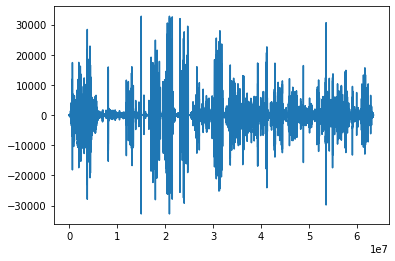

In [149]:
plt.plot(data)

# High pass filter
used a high pass filter to clean the noise from the dc signal setting the lowest frequeency possible to be 10 hz

In [150]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='band', analog=False, output='sos')
    return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfiltfilt(sos, data)
    return y

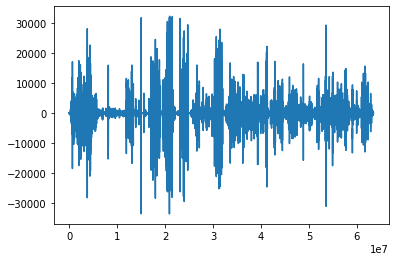

In [151]:
data = butter_bandpass_filter(data, BANDPASS_FREQ[0], BANDPASS_FREQ[1], fs)
plt.plot(data)

# remove additional data

In [285]:
meta_data = meta_data[meta_data.description != ' [MISC]']
meta_data = meta_data[~meta_data['description'].astype(str).str.startswith(' (')]
meta_data = meta_data[~meta_data['description'].astype(str).str.startswith(' Emotion category elation')]
meta_data = meta_data[~meta_data['description'].astype(str).str.startswith('  [MISC]')]


# divide the data

In [286]:
voice_time_limits = meta_data["sound limits"]
voice_time_limits = [i.split(" ")[0:2] for i in voice_time_limits]
voice_time_limits = np.array(voice_time_limits)
voice_time_limits = voice_time_limits.astype(np.float)
description = meta_data["description"]
description = [i.split(",")[0].strip() for i in description]

In [287]:
description

['neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'panic',
 'panic',
 'panic',
 'panic',
 'panic',
 'panic',
 'panic',
 'panic',
 'panic',
 'panic',
 'panic',
 'panic',
 'panic',
 'panic',
 'panic',
 'panic',
 'panic',
 'panic',
 'anxiety',
 'anxiety',
 'anxiety',
 'anxiety',
 'anxiety',
 'anxiety',
 'anxiety',
 'anxiety',
 'anxiety',
 'anxiety',
 'anxiety',
 'anxiety',
 'anxiety',
 'anxiety',
 'anxiety',
 'anxiety',
 'hot anger',
 '

In [288]:
data_number = 0
divided_data = []
for i in voice_time_limits:
    startingpoint = int(i[0]*fs)
    endingpoint = int(i[1]*fs)
    divided_data.append(data[startingpoint:endingpoint])
    data_number +=1
np_data = np.asarray(divided_data)

In [289]:
np_data.shape

(287,)

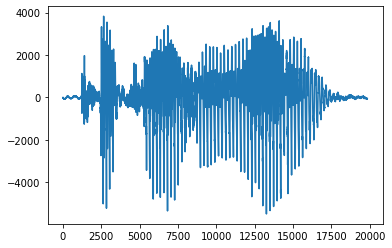

In [290]:
plt.plot(divided_data[2])

In [291]:
np.save("../segmented_voice_data",divided_data)

In [292]:
MFCC = []
for i in np_data:
    i = np.asarray(i)
    MFCC.append(librosa.feature.mfcc(y = i, sr = fs, n_mfcc =13, n_fft = 100, n_mels = 1000))

/usr/local/lib/python3.7/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


In [293]:
import python_speech_features
MFCC2 = []
for i in np_data:
    i = np.asarray(i)
    MFCC2.append(python_speech_features.base.mfcc(i, samplerate=fs, 
                                 winlen=0.025, winstep=0.01, numcep=13, 
                                 nfilt=26, nfft=552))
first_cooef = []
for i in MFCC2[140]:
    first_cooef.append(i[1])

In [294]:
len(MFCC2), len(MFCC2[0]), len(MFCC2[0][0])

(287, 101, 13)

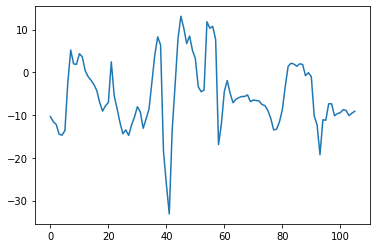

In [295]:
plt.plot(first_cooef)

In [301]:
description[-1]

'contempt'

In [297]:
MFCC3 = []
cache = {}

for data_point in MFCC2:
    for time_segment in data_point:
        if (data_point[0] == time_segment).all():
            for i in range(13):
                cache[i] = [time_segment[i]]
        else:
            for i in range(13):
                cache[i] = np.concatenate((cache[i], [time_segment[i]]))
    cached_variables = []
    cache_grad = []
    for i in range(13):
        cache_grad.append(np.gradient(cache[i]))
        cached_variables.append([np.mean(cache[i]), np.median(cache[i]), np.var(cache[i]), 
                           np.min(cache[i]), np.max(cache[i]), 
                                 np.mean(cache_grad[i]), np.var(cache_grad[i])])
    MFCC3.append(np.hstack(np.hstack(cached_variables)))

In [298]:
len(MFCC3), len(MFCC3[0]), len(cached_variables[0])

(287, 91, 7)

In [309]:
from sklearn.neural_network import MLPClassifier

In [310]:
mlp = MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=15000)

In [314]:
x = MFCC3
y = []
for i in description:
    if i == 'neutral':
        y.append(0)
    elif i == 'disgust':
        y.append(1)
    elif i == 'panic':
        y.append(1)
    elif i == 'anxiety':
        y.append(2)
    elif i == 'hot anger':
        y.append(3)
    elif i == 'cold anger':
        y.append(4)
    elif i == 'despair':
        y.append(5)
    elif i == 'sadness':
        y.append(6)
    elif i == 'elation':
        y.append(7)
    elif i == 'happy':
        y.append(8)
    elif i == 'interest':
        y.append(9)
    elif i == 'boredom':
        y.append(10)
    elif i == 'shame':
        y.append(11)
    elif i == 'pride':
        y.append(12)
    elif i == 'contempt':
        y.append(13)
    else:
        print(i)
        break

In [315]:
mlp.fit(x,y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(13, 13, 13), learning_rate='constant',
              learning_rate_init=0.001, max_iter=15000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [316]:
predictions = mlp.predict(x)
from sklearn.metrics import classification_report,confusion_matrix

print(confusion_matrix(y,predictions))
print(classification_report(y,predictions))

[[ 8  1  0  0  0  0  1  0  2  0  0  0  0  7]
 [ 0 43  0  0  2  0  0  0  0  0  0  1  0  4]
 [ 0  2  9  0  0  2  0  0  0  0  0  0  0  3]
 [ 0  9  0  3  0  0  0  0  0  0  0  0  0  2]
 [ 0  0  0  0  0  0  0  2  4  0  0  0  1  8]
 [ 0  3  0  0  0  8  0  0  2  1  0  0  0  1]
 [ 0  0  0  0  0  3  8  0  0  0  0  1  1  4]
 [ 0  0  0  0  0  2  1  8  4  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0 22  0  0  0  0  2]
 [ 0 11  0  0  0  1  0  0  0  4  0  0  0  1]
 [ 1  0  0  0  0  0  0  1  3  0  9  0  0  3]
 [ 0  0  0  0  0  0  0  0  4  0  0  1  0 16]
 [ 0  0  0  0  0  0  0  1 11  0  0  1  5  5]
 [ 2  0  0  0  0  0  0  0  8  0  0  0  0 13]]
              precision    recall  f1-score   support

           0       0.73      0.42      0.53        19
           1       0.62      0.86      0.72        50
           2       1.00      0.56      0.72        16
           3       1.00      0.21      0.35        14
           4       0.00      0.00      0.00        15
           5       0.50      0.53      0.52 